# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.410274,True,3.675472
1,1.855836,True,6.601687
2,1.319158,True,5.644549
3,1.500462,True,7.575296
4,1.728572,True,8.543099
...,...,...,...
995,2.585477,True,9.100073
996,-0.067992,False,-0.239890
997,1.525346,True,6.770723
998,0.483875,True,5.658186


<AxesSubplot:xlabel='v0'>

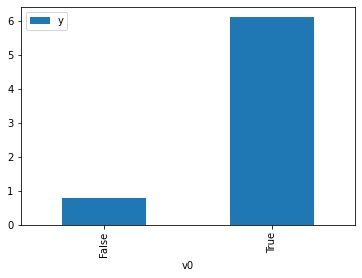

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

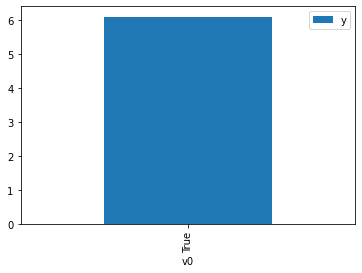

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.386505,False,2.025023,0.084705,11.805609
1,1.921788,False,1.297468,0.036153,27.660060
2,0.481220,False,-0.909901,0.298863,3.346013
3,1.042176,False,1.524698,0.141957,7.044402
4,1.387393,False,0.431245,0.084589,11.821824
...,...,...,...,...,...
995,-0.628891,False,-0.484371,0.735012,1.360522
996,1.012281,False,0.396783,0.148212,6.747101
997,1.625321,False,2.024835,0.058251,17.167197
998,1.921788,False,1.297468,0.036153,27.660060


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,2.228865,True,9.431730,0.978145,1.022343
1,1.079395,True,6.661005,0.865521,1.155373
2,1.804144,True,5.954310,0.956257,1.045744
3,1.728563,True,6.330799,0.950601,1.051966
4,0.727510,True,5.352766,0.780442,1.281325
...,...,...,...,...,...
995,0.724866,True,5.710369,0.779677,1.282583
996,-0.140528,True,4.904026,0.451091,2.216845
997,0.931611,True,5.166575,0.833771,1.199370
998,0.706558,True,7.748839,0.774325,1.291448


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          1.732e+04
Date:                Fri, 12 Aug 2022   Prob (F-statistic):                        0.00
Time:                        22:18:21   Log-Likelihood:                         -1376.3
No. Observations:                1000   AIC:                                      2757.
Df Residuals:                     998   BIC:                                      2766.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2509      0.035     35.913      0.000       1.183       1.319
x2             4.9835      0.055     91.303      0.000       4.876       5.091
==============================================================================
Omnibus:                        1.070   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.586   Jarque-Bera (JB):                0.971
Skew:                           0.071   Prob(JB):                        0.615
Kurtosis:                       3.055   Cond. No.                         3.07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""